# Blocking identifiaction with the Reversal index

In [27]:
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm
import sys, os
sys.path.append("/home/b/b382006/tools/Blocking/brunner/blocking/")
from BlockingDetection import Blocking

## Compute blocks - test run

In [9]:
### blocking method based on the original Code of Lukas Brunner
xr_in=xr.open_mfdataset('/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/z/6H/z500_IFS_9-FESOM_5-production_20*')
#xr_in=xr.open_mfdataset('/scratch/b/b382006/ifs/from_9km_to_1degree/Y2020M02/ICMUAhr2n+0*')
#xr_in = xr.open_mfdataset('/scratch/b/b382006/ifs/from_9km_to_1degree/Y*/ICMUAhr2n+0*',concat_dim='time',combine='nested')
#xr_in = xr.open_mfdataset('/scratch/b/b382006/era5/daily/era5_regio_prl_2004*')

In [10]:
###xr_in=xr_in.resample(time='6H').mean(dim='time',keep_attrs=True) #6 hourly mean
xr_in

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, time: 43756)
Coordinates:
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * time     (time) datetime64[ns] 2020-01-20 ... 2049-12-31T18:00:00
Data variables:
    z        (time, lat, lon) float64 dask.array<chunksize=(48, 181, 360), meta=np.ndarray>

In [11]:
#change to yyyy mm dd - daily icon
xr_in['time']=xr_in.indexes['time'].normalize()


In [6]:
###=== rename zfull
#xr_in=xr_in.rename({'z':'GeopotentialHeight'})

In [6]:
###for era5
#dxr_in=xr_in.drop_dims('bnds')
#dxr_in

In [19]:
### Take geopotential
###icon
#in_z_500=xr_in.GeopotentialHeight.sel(plev=50000.0)
#daily_z=in_z_500.resample(time='1D').mean(dim='time',keep_attrs=True) #daily mean
#dataset_z=xr.DataArray.to_dataset(daily_z)
#dataset_z.GeopotentialHeight

###==era5
#dataset_z=xr_in.resample(time='1D').mean(dim='time',keep_attrs=True) #daily mean

### daily era5/icon
#dataset_z=dxr_in

#dataset_z.time.attrs['standard_name'] = 'time'
#dataset_z.time.attrs['axis'] = 'T'
#dataset_z.time

#xr_in.time.attrs['standard_name'] = 'time'
#xr_in.time.attrs['axis'] = 'T'
#xr_in.time


In [12]:
daily_z=xr_in.resample(time='1D').mean(dim='time',keep_attrs=True) #daily mean
daily_z

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, time: 10939)
Coordinates:
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2049-12-31
Data variables:
    z        (time, lat, lon) float64 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>

In [21]:
#OUTPATH = dataset_z.replace(
#    'geopotential', 'blocking').replace('.nc', '_bf_3D.nc')
OUTPATH='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/IB.nc'
OUTPATH2='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/ExtendB.nc'
OUTPATH3='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/blocking.nc'

In [22]:
### intitate
blk = Blocking()
#blk.import_xarray(dataset_z)
blk.import_xarray(daily_z)
blk.ds

<xarray.Dataset>
Dimensions:             (lon: 360, lat: 181, time: 347)
Coordinates:
  * lon                 (lon) float64 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat                 (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * time                (time) datetime64[ns] 2020-01-20 ... 2020-12-31
Data variables:
    z                   (time, lat, lon) float64 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    GeopotentialHeight  (time, lat, lon) float64 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>

In [23]:
## pre-processing
##blk.get_time_subset(months='DJF')
##blk.calculate_daily_mean()

###era5
blk.calculate_gph_from_gp() # calculate geopotential height

#blk.ds.time
#blk.ds.GeopotentialHeight
blk.ds.GeopotentialHeight

2024-03-06 14:46:59,867 - root - INFO - Calculated GPH from GP


<xarray.DataArray 'GeopotentialHeight' (time: 347, lat: 181, lon: 360)>
dask.array<truediv, shape=(347, 181, 360), dtype=float64, chunksize=(1, 181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-12-31
Attributes:
    units:    m
    history:  Calculated from z with g=9.80665

In [24]:
blk.set_up(time_name='time', longitude_name='lon', latitude_name='lat')

blk.calculate_gradients(delta_degree=15)

blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

2024-03-06 14:47:04,441 - root - INFO - Set time grid distance 1
2024-03-06 14:47:04,442 - root - INFO - Set lon grid distance 1.0
2024-03-06 14:47:04,442 - root - INFO - Set lat grid distance 1.0
2024-03-06 14:47:04,443 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2024-03-06 14:47:04,500 - root - INFO - Calculating gradients... DONE
2024-03-06 14:47:04,500 - root - INFO - Calculating IB as IB...
2024-03-06 14:47:08,806 - root - INFO - Calculating IB... DONE


In [25]:
# 
blk.calculate_eib(min_extent_degree=15)


2024-03-06 14:47:11,988 - root - INFO - Calculating extended IB as ExtendedIB...
2024-03-06 14:47:12,658 - root - INFO - Calculating extended IB... DONE


In [26]:
# 
blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=7,
    latitude_pm_degree=2)

#    stationary_pm_days=2,
#    longitude_pm_degree=7.5,
#    latitude_pm_degree=2.5)


2024-03-06 14:47:17,191 - root - INFO - Calculating blocking as Blocking...
2024-03-06 14:47:17,321 - root - INFO - Calculating time step... 0%
2024-03-06 14:47:26,508 - root - INFO - Calculating time step... 10%
2024-03-06 14:47:44,048 - root - INFO - Calculating time step... 20%
2024-03-06 14:47:54,182 - root - INFO - Calculating time step... 30%
2024-03-06 14:48:05,544 - root - INFO - Calculating time step... 40%
2024-03-06 14:48:17,599 - root - INFO - Calculating time step... 50%
2024-03-06 14:48:24,417 - root - INFO - Calculating time step... 60%
2024-03-06 14:48:31,346 - root - INFO - Calculating time step... 70%
2024-03-06 14:48:41,846 - root - INFO - Calculating time step... 80%
2024-03-06 14:48:50,655 - root - INFO - Calculating time step... 90%
2024-03-06 14:48:58,422 - root - INFO - Calculating blocking... DONE


In [27]:
### Plotting one time step
blk
#tmd=blk.ds.GeopotentialHeight.isel(time=50)
#tmd.plot()


Class Blocking: 
<xarray.Dataset>
Dimensions:                             (lon: 360, lat: 181, time: 347)
Coordinates:
  * lon                                 (lon) float64 -179.0 -178.0 ... 180.0
  * lat                                 (lat) float64 -90.0 -89.0 ... 89.0 90.0
  * time                                (time) datetime64[ns] 2020-01-20 ... ...
Data variables:
    GeopotentialHeight                  (time, lat, lon) float64 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    GeopotentialHeightGradient_north    (time, lat, lon) float64 dask.array<chunksize=(1, 166, 360), meta=np.ndarray>
    GeopotentialHeightGradient_south    (time, lat, lon) float64 dask.array<chunksize=(1, 15, 360), meta=np.ndarray>
    GeopotentialHeightGradient_equator  (time, lat, lon) float64 dask.array<chunksize=(1, 75, 360), meta=np.ndarray>
    IB                                  (time, lat, lon) int64 0 0 0 0 ... 0 0 0
    ExtendedIB                          (time, lat, lon) int64 0 0 0 0 ... 

In [28]:
# save to disk 
blk.save(OUTPATH, 'IB')
blk.save(OUTPATH2, 'ExtendedIB')
blk.save(OUTPATH3, 'Blocking')

2024-03-06 14:49:22,108 - root - INFO - Saved /scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/IB.nc
2024-03-06 14:49:22,249 - root - INFO - Saved /scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/ExtendB.nc
2024-03-06 14:49:22,457 - root - INFO - Saved /scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/blocking.nc


In [29]:
block = xr.open_dataset(OUTPATH)
block2 = xr.open_dataset(OUTPATH2)
block3 = xr.open_dataset(OUTPATH3)

ntime=len(block.time)
ntime

347

In [30]:
### accumulate 
acc=block.IB.sum(dim='time')
acc2=block2.ExtendedIB.sum(dim='time')
acc3=block3.Blocking.sum(dim='time')
acc = acc/ntime
acc *= 100

acc2 = acc2/ntime
acc2 *= 100

acc3 = acc3/ntime
acc3 *= 100

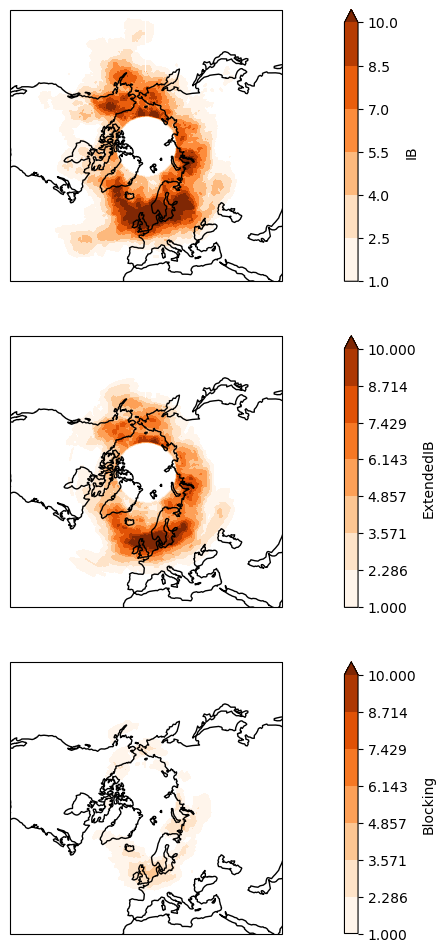

In [34]:

###=== plotting
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(16, 12), subplot_kw={'projection': ccrs.NorthPolarStereo()})
#fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
#std_djf.plot(ax=ax1,levels=np.linspace(200,800,11), cmap='YlOrRd', extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True)
#dstd_djf[0,:,:].
acc.plot.contourf(ax=ax1,levels = np.linspace(1,10,7),cmap='Oranges',extend = 'max', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

acc2.plot.contourf(ax=ax2,levels = np.linspace(1,10,8),cmap='Oranges',extend = 'max', transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

acc3.plot.contourf(ax=ax3,levels = np.linspace(1,10,8),cmap='Oranges',extend = 'max', transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

#acc.plot.contour(colors='grey', linewidths=0.8, levels = np.linspace(2,16,8), transform=ccrs.PlateCarree())





## Compute for whole period year by year

In [28]:
### open files
### nextgems
##xr_in=xr.open_mfdataset('/scratch/b/b382006/nextgems/prefinal/ngc4008/zg/daily/zg50000_icon_prefinal_day*')
###cmip6 ["MRI-ESM2-0","ACCESS-CM2","EC-Earth3","CESM2-WACCM","MIROC6","MPI-ESM1-2-HR","MPI-ESM1-2-LR","CESM2"]

exper='ssp585'
inpath="/scratch/b/b382006/cmip6/"+exper+"/"
model="MRI-ESM2-0"
member_id="r1i1p1f1"
infile=inpath+model+"/"+member_id+"/daily/50000/cmip6_zg_*"
#xr_in=xr.open_mfdataset('/scratch/b/b382006/cmip6/ssp370/CESM2-WACCM/r1i1p1f1/daily/50000/cmip6_zg_*')
xr_in=xr.open_mfdataset(infile)

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [29]:
#xr_in

In [30]:
###==output
###nextgems
#dir_res='/scratch/b/b382006/nextgems/prefinal/ngc4008/block/ABS_Z500/'
##dir_res='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/'

###cmip6 
dir_res=inpath+model+"/"+member_id+"/block/ABS_500"

y0=2061 #1979, 2025, 2061
yn=2101 #2015, 2050, 2101
years=np.arange(y0,yn,1)

In [31]:
print(years,dir_res)

[2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074
 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088
 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100] /scratch/b/b382006/cmip6/ssp585/MRI-ESM2-0/r1i1p1f1/block/ABS_500


In [32]:
## ICON has GH, only rename it
### rename zfull
xr_in=xr_in.rename({'zg':'GeopotentialHeight'})

In [ ]:
for year in years:
    ofile= "block_ABS-Z500_"+str(year)+".nc"

    if not os.path.exists(dir_res):
        os.makedirs(dir_res)

    OUTPATH=dir_res+'/'+ofile

    print(OUTPATH)

    ### IFS Compute yearly
#    data=daily_z.sel(time=daily_z.time.dt.year.isin([year]))
    ### ICON Compute yearly
    data=xr_in.sel(time=xr_in.time.dt.year.isin([year]))

###=== intitate
    blk = Blocking()

    blk.import_xarray(data)

    ### not for ICON
#    blk.calculate_gph_from_gp(gp_name='z') # calculate geopotential height

    blk.set_up(time_name='time',longitude_name='lon', latitude_name='lat')

    blk.calculate_gradients(delta_degree=15)

    blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

#
    blk.calculate_eib(min_extent_degree=15)

#
    blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

# save to disk
    blk
    blk.save(OUTPATH, 'Blocking')

    data.close()

2024-05-27 14:22:28,856 - root - INFO - Set time grid distance 1
2024-05-27 14:22:28,857 - root - INFO - Set lon grid distance 1
2024-05-27 14:22:28,858 - root - INFO - Set lat grid distance 1.0
2024-05-27 14:22:28,858 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2024-05-27 14:22:28,885 - root - INFO - Calculating gradients... DONE
2024-05-27 14:22:28,885 - root - INFO - Calculating IB as IB...


/scratch/b/b382006/cmip6/ssp585/MRI-ESM2-0/r1i1p1f1/block/ABS_500/block_ABS-Z500_2061.nc


2024-05-27 14:22:30,021 - root - INFO - Calculating IB... DONE
2024-05-27 14:22:30,022 - root - INFO - Calculating extended IB as ExtendedIB...
2024-05-27 14:22:30,535 - root - INFO - Calculating extended IB... DONE
2024-05-27 14:22:30,536 - root - INFO - Calculating blocking as Blocking...
2024-05-27 14:22:30,656 - root - INFO - Calculating time step... 0%
2024-05-27 14:22:41,126 - root - INFO - Calculating time step... 10%
2024-05-27 14:22:50,939 - root - INFO - Calculating time step... 20%
2024-05-27 14:22:59,684 - root - INFO - Calculating time step... 30%
2024-05-27 14:23:09,485 - root - INFO - Calculating time step... 40%
2024-05-27 14:23:20,695 - root - INFO - Calculating time step... 50%
2024-05-27 14:23:30,083 - root - INFO - Calculating time step... 60%
2024-05-27 14:23:36,289 - root - INFO - Calculating time step... 70%
2024-05-27 14:23:41,638 - root - INFO - Calculating time step... 80%
2024-05-27 14:23:46,481 - root - INFO - Calculating time step... 90%
2024-05-27 14:23:53

/scratch/b/b382006/cmip6/ssp585/MRI-ESM2-0/r1i1p1f1/block/ABS_500/block_ABS-Z500_2062.nc


2024-05-27 14:23:54,981 - root - INFO - Calculating IB... DONE
2024-05-27 14:23:54,982 - root - INFO - Calculating extended IB as ExtendedIB...
2024-05-27 14:23:55,610 - root - INFO - Calculating extended IB... DONE
2024-05-27 14:23:55,611 - root - INFO - Calculating blocking as Blocking...
2024-05-27 14:23:55,732 - root - INFO - Calculating time step... 0%
2024-05-27 14:24:05,942 - root - INFO - Calculating time step... 10%
2024-05-27 14:24:19,557 - root - INFO - Calculating time step... 20%
2024-05-27 14:24:35,615 - root - INFO - Calculating time step... 30%
2024-05-27 14:24:50,046 - root - INFO - Calculating time step... 40%
2024-05-27 14:25:02,077 - root - INFO - Calculating time step... 50%
2024-05-27 14:25:08,743 - root - INFO - Calculating time step... 60%
2024-05-27 14:25:18,164 - root - INFO - Calculating time step... 70%
2024-05-27 14:25:26,258 - root - INFO - Calculating time step... 80%
2024-05-27 14:25:33,716 - root - INFO - Calculating time step... 90%
2024-05-27 14:25:43

/scratch/b/b382006/cmip6/ssp585/MRI-ESM2-0/r1i1p1f1/block/ABS_500/block_ABS-Z500_2063.nc


2024-05-27 14:25:44,693 - root - INFO - Calculating IB... DONE
2024-05-27 14:25:44,694 - root - INFO - Calculating extended IB as ExtendedIB...
2024-05-27 14:25:45,360 - root - INFO - Calculating extended IB... DONE
2024-05-27 14:25:45,361 - root - INFO - Calculating blocking as Blocking...
2024-05-27 14:25:45,497 - root - INFO - Calculating time step... 0%
2024-05-27 14:25:53,558 - root - INFO - Calculating time step... 10%
2024-05-27 14:26:04,925 - root - INFO - Calculating time step... 20%
2024-05-27 14:26:12,742 - root - INFO - Calculating time step... 30%
2024-05-27 14:26:24,809 - root - INFO - Calculating time step... 40%
2024-05-27 14:26:33,249 - root - INFO - Calculating time step... 50%
2024-05-27 14:26:44,715 - root - INFO - Calculating time step... 60%
2024-05-27 14:26:52,631 - root - INFO - Calculating time step... 70%
2024-05-27 14:27:01,479 - root - INFO - Calculating time step... 80%
2024-05-27 14:27:08,586 - root - INFO - Calculating time step... 90%
2024-05-27 14:27:16

/scratch/b/b382006/cmip6/ssp585/MRI-ESM2-0/r1i1p1f1/block/ABS_500/block_ABS-Z500_2064.nc


2024-05-27 14:27:17,736 - root - INFO - Calculating IB... DONE
2024-05-27 14:27:17,737 - root - INFO - Calculating extended IB as ExtendedIB...
2024-05-27 14:27:18,372 - root - INFO - Calculating extended IB... DONE
2024-05-27 14:27:18,373 - root - INFO - Calculating blocking as Blocking...
2024-05-27 14:27:18,497 - root - INFO - Calculating time step... 0%
2024-05-27 14:27:23,986 - root - INFO - Calculating time step... 10%
2024-05-27 14:27:30,043 - root - INFO - Calculating time step... 20%
2024-05-27 14:27:38,161 - root - INFO - Calculating time step... 30%
2024-05-27 14:27:51,445 - root - INFO - Calculating time step... 40%
2024-05-27 14:28:04,983 - root - INFO - Calculating time step... 50%
2024-05-27 14:28:19,456 - root - INFO - Calculating time step... 60%
2024-05-27 14:28:25,091 - root - INFO - Calculating time step... 70%
2024-05-27 14:28:28,228 - root - INFO - Calculating time step... 80%
2024-05-27 14:28:34,993 - root - INFO - Calculating time step... 90%
2024-05-27 14:28:42

/scratch/b/b382006/cmip6/ssp585/MRI-ESM2-0/r1i1p1f1/block/ABS_500/block_ABS-Z500_2065.nc


2024-05-27 14:28:43,657 - root - INFO - Calculating IB... DONE
2024-05-27 14:28:43,658 - root - INFO - Calculating extended IB as ExtendedIB...
2024-05-27 14:28:44,302 - root - INFO - Calculating extended IB... DONE
2024-05-27 14:28:44,303 - root - INFO - Calculating blocking as Blocking...
2024-05-27 14:28:44,435 - root - INFO - Calculating time step... 0%
2024-05-27 14:28:54,632 - root - INFO - Calculating time step... 10%
2024-05-27 14:29:01,037 - root - INFO - Calculating time step... 20%
2024-05-27 14:29:11,883 - root - INFO - Calculating time step... 30%
2024-05-27 14:29:22,827 - root - INFO - Calculating time step... 40%
2024-05-27 14:29:35,289 - root - INFO - Calculating time step... 50%
2024-05-27 14:29:45,565 - root - INFO - Calculating time step... 60%
2024-05-27 14:29:51,034 - root - INFO - Calculating time step... 70%
2024-05-27 14:29:58,633 - root - INFO - Calculating time step... 80%
2024-05-27 14:30:05,977 - root - INFO - Calculating time step... 90%
2024-05-27 14:30:10

/scratch/b/b382006/cmip6/ssp585/MRI-ESM2-0/r1i1p1f1/block/ABS_500/block_ABS-Z500_2066.nc


2024-05-27 14:30:12,081 - root - INFO - Calculating IB... DONE
2024-05-27 14:30:12,082 - root - INFO - Calculating extended IB as ExtendedIB...
2024-05-27 14:30:12,625 - root - INFO - Calculating extended IB... DONE
2024-05-27 14:30:12,626 - root - INFO - Calculating blocking as Blocking...
2024-05-27 14:30:12,766 - root - INFO - Calculating time step... 0%
2024-05-27 14:30:18,311 - root - INFO - Calculating time step... 10%
2024-05-27 14:30:29,905 - root - INFO - Calculating time step... 20%
2024-05-27 14:30:42,326 - root - INFO - Calculating time step... 30%
2024-05-27 14:30:53,602 - root - INFO - Calculating time step... 40%
2024-05-27 14:30:59,156 - root - INFO - Calculating time step... 50%
2024-05-27 14:31:10,853 - root - INFO - Calculating time step... 60%
2024-05-27 14:31:17,911 - root - INFO - Calculating time step... 70%
2024-05-27 14:31:27,624 - root - INFO - Calculating time step... 80%
2024-05-27 14:31:33,858 - root - INFO - Calculating time step... 90%
2024-05-27 14:31:45

/scratch/b/b382006/cmip6/ssp585/MRI-ESM2-0/r1i1p1f1/block/ABS_500/block_ABS-Z500_2067.nc


2024-05-27 14:31:46,617 - root - INFO - Calculating IB... DONE
2024-05-27 14:31:46,618 - root - INFO - Calculating extended IB as ExtendedIB...
2024-05-27 14:31:47,234 - root - INFO - Calculating extended IB... DONE
2024-05-27 14:31:47,235 - root - INFO - Calculating blocking as Blocking...
2024-05-27 14:31:47,348 - root - INFO - Calculating time step... 0%
2024-05-27 14:32:00,599 - root - INFO - Calculating time step... 10%
2024-05-27 14:32:13,725 - root - INFO - Calculating time step... 20%


In [ ]:
### Compute average
#OUTPATH

## Analyzing outputs (frequency)

In [69]:
###===IFS
#inpath='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/'
###===ICON
inpath='/scratch/b/b382006/nextgems/prefinal/ngc4008/block/ABS_Z500/'

In [70]:
block = xr.open_mfdataset(inpath+'block_ABS-Z500*')
ntime=len(block.time)
ntime

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


10957

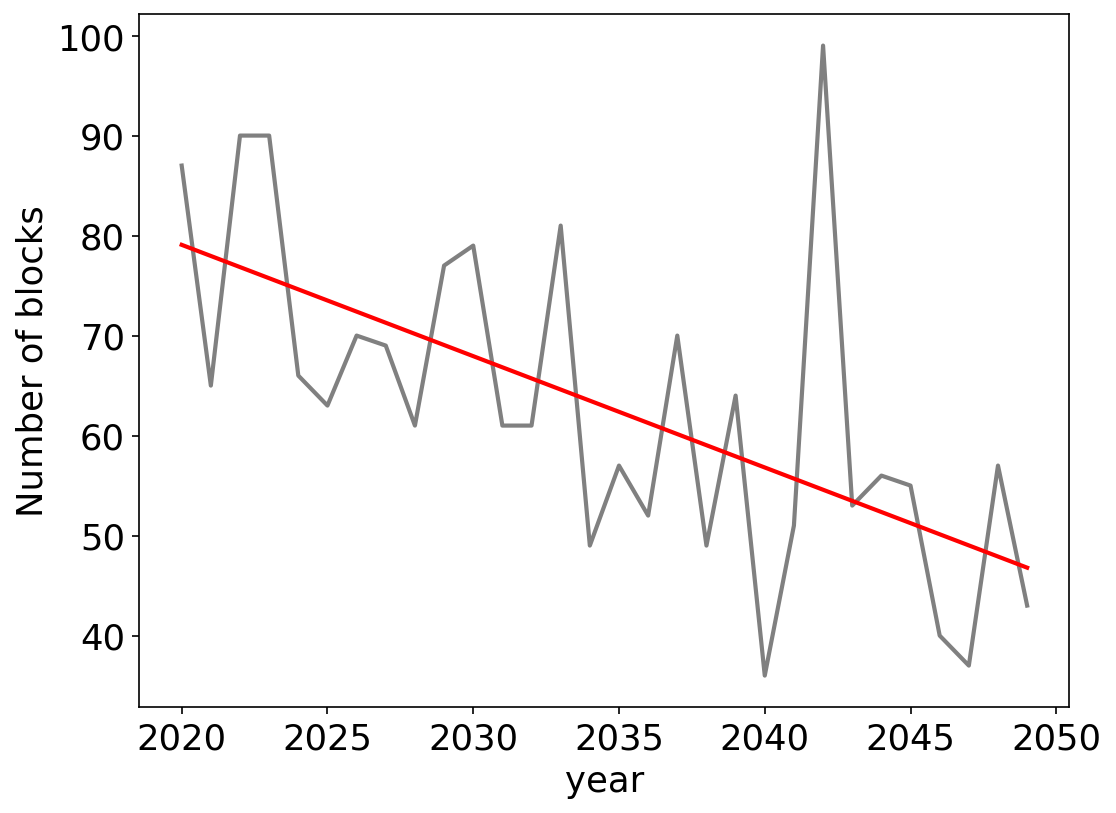

In [71]:
### Computing trend
###NA
sample=block.sel(lat=slice(40,65),lon=slice(5,40))
###NP
#sample=block.sel(lat=slice(50,75),lon=slice(160,180))
tserie=sample.mean(dim=["lat", "lon"])
#tserie['Blocking']
tmp=xr.where(tserie['Blocking']>0,1,0).compute()
serie=tmp.groupby("time.year").sum()

x=np.arange(serie.size)
fit=np.polyfit(x,serie.values,1)
fit_fn=np.poly1d(fit)

### Plot
fig,ax=plt.subplots(figsize=(8, 6), dpi=150)
serie.plot(color='grey', linestyle='-',lw=2)
plt.ylabel('Number of blocks', fontsize=17)
plt.xlabel('year',fontsize=17)
plt.plot(serie.year,fit_fn(x),'r-',lw=2)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

In [72]:
### Compute frequency by periods

In [73]:
y0='2020' ##2020
yn='2025' ##2025
first=block.sel(time=slice(y0,yn))
y0='2044' ## 2039, 2044
yn='2049' ## 2044, 2049
last=block.sel(time=slice(y0,yn))
last

<xarray.Dataset>
Dimensions:   (lon: 360, lat: 181, time: 2192)
Coordinates:
  * lon       (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat       (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * time      (time) datetime64[ns] 2044-01-01 2044-01-02 ... 2049-12-31
Data variables:
    Blocking  (time, lat, lon) int64 dask.array<chunksize=(366, 181, 360), meta=np.ndarray>

In [74]:
### accumulate 
acc_first=first.Blocking.sum(dim='time')
acc_first = acc_first/len(first.time)
acc_first *= 100

In [75]:
acc_last=last.Blocking.sum(dim='time')
acc_last = acc_last/len(last.time)
acc_last *= 100

In [76]:
### compute difference
chgs=acc_last-acc_first

In [77]:
### select seasons
winter=[10,11,12,1,2,3]
summer=[4,5,6,7,8,9]

first_djf = first.sel(time=first.time.dt.month.isin(winter))
last_djf = last.sel(time=last.time.dt.month.isin(winter))

acc_first_djf=first_djf.Blocking.sum(dim='time')
acc_first_djf = acc_first_djf/len(first_djf.time)
acc_first_djf *= 100

acc_last_djf=last_djf.Blocking.sum(dim='time')
acc_last_djf = acc_last_djf/len(last_djf.time)
acc_last_djf *= 100

chgs_djf=acc_last_djf-acc_first_djf

first_jja = first.sel(time=first.time.dt.month.isin(summer))
last_jja = last.sel(time=last.time.dt.month.isin(summer))

acc_first_jja = first_jja.Blocking.sum(dim='time')
acc_first_jja = acc_first_jja/len(first_jja.time)
acc_first_jja *= 100

acc_last_jja = last_jja.Blocking.sum(dim='time')
acc_last_jja = acc_last_jja/len(last_jja.time)
acc_last_jja *= 100

chgs_jja=acc_last_jja-acc_first_jja

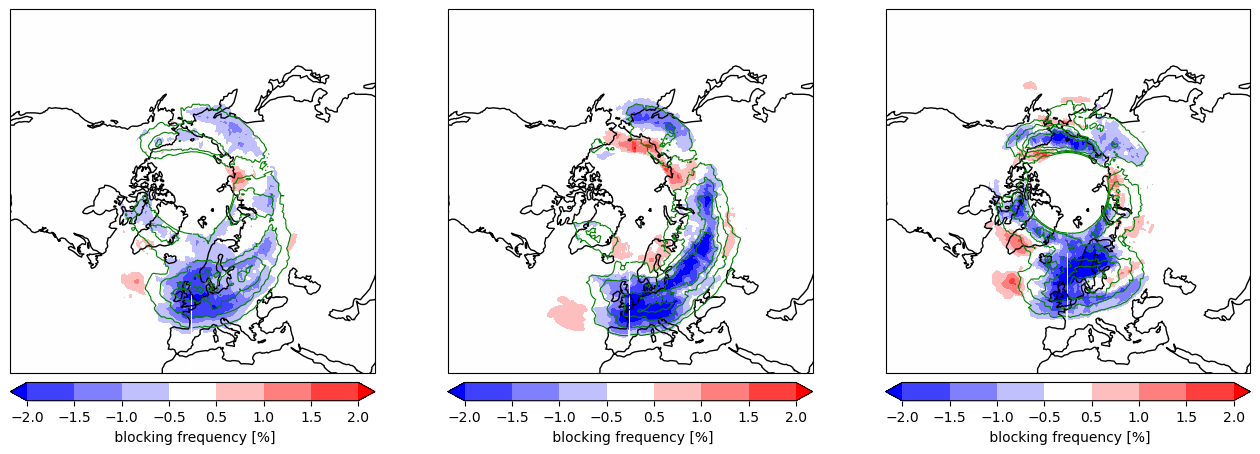

In [78]:
###=== plotting
###North
levs=[1,2,3,4]
wlevs=[-2,-1.5,-1,-0.5,0.5,1,1.5,2]
exts=[-180, 180, 30, 90]
###South
#levs=[0.2,0.6,1]
#wlevs=[-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5]
#exts=[-180, 180, -30, -90]

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 12), subplot_kw={'projection': ccrs.NorthPolarStereo()})
#fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 12), subplot_kw={'projection': ccrs.SouthPolarStereo()})

chgs.plot.contourf(ax=ax1,levels = wlevs,cmap='bwr',extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': ' blocking frequency [%]','orientation':'horizontal','pad':0.01})
acc_first.plot.contour(ax=ax1,colors='g', linewidths=0.8, levels=levs, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_extent(exts, crs=ccrs.PlateCarree())

chgs_djf.plot.contourf(ax=ax2,levels = wlevs,cmap='bwr',extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': ' blocking frequency [%]','orientation':'horizontal','pad':0.01})
acc_first_djf.plot.contour(ax=ax2,colors='g', linewidths=0.8, levels=levs, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_extent(exts, crs=ccrs.PlateCarree())

chgs_jja.plot.contourf(ax=ax3,levels = wlevs,cmap='bwr',extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': ' blocking frequency [%]','orientation':'horizontal','pad':0.01})
acc_first_jja.plot.contour(ax=ax3,colors='g', linewidths=0.8, levels=levs, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_extent(exts, crs=ccrs.PlateCarree())


In [79]:
from scipy.ndimage import gaussian_filter
import cartopy.util as cutil
import matplotlib.patches as mpatches
import matplotlib.path as mpath

### BIAS mean ensamble
chgs_fil = gaussian_filter(chgs_jja, sigma=0.1)
acc_first_fil = gaussian_filter(acc_first_jja, sigma=1.0)

chgs_fil_new, clon = cutil.add_cyclic(chgs_fil, chgs.lon)

### Compute a circle in axes coordinates, which we can use as a boundary
### for the map. We can pan/zoom as much as we like - the boundary will be
### permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [80]:
#chgs_fil
#chgs_jja

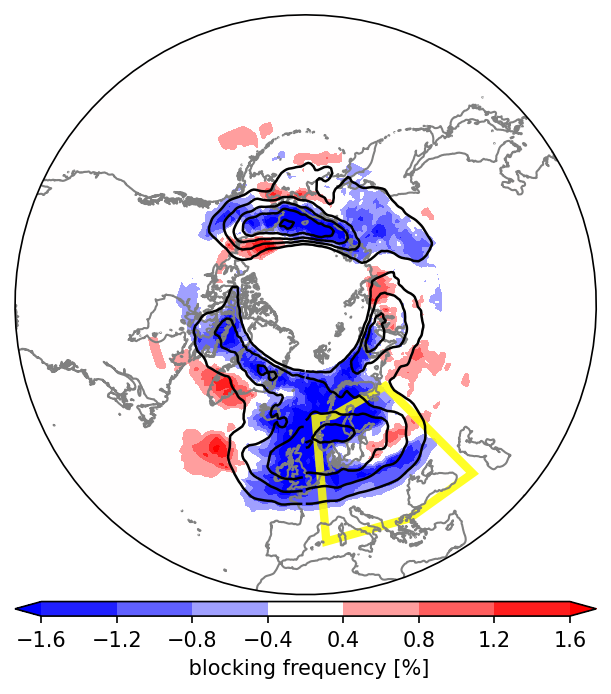

In [81]:
###
### changes
import matplotlib.patches as mpatches

clevels=[1,2,3,4,5]
#flevels=[-2,-1.5,-1,-0.5,0.5,1,1.5,2]
flevels=[-1.6,-1.2,-0.8,-0.4,0.4,0.8,1.2,1.6]
#flevels=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]

fig, ax3 = plt.subplots(1, 1, figsize=(5, 6),dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})

ax3.set_boundary(circle, transform=ax3.transAxes)

###==== second panel
#im=chgs_jja.plot(ax=ax3,levels=flevels, cmap='bwr', extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=False)
im =ax3.contourf(clon, chgs.lat,chgs_fil_new, levels=flevels, cmap='bwr', extend = 'both', transform=ccrs.PlateCarree())

im2 =ax3.contour(acc_first.lon, acc_first.lat,acc_first_fil, colors='k', linewidths=1.2, levels=clevels, transform=ccrs.PlateCarree())

ax3.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

ax3.coastlines(resolution='50m', color='grey', linestyle='-', alpha=1)
#ax3.set_title('IFS (2044 to 2049) - (2020 to 2025)')

ax3.add_patch(mpatches.Rectangle(xy=[5, 40], width=40, height=25,\
                                 facecolor='none',alpha=0.85,edgecolor="yellow",linewidth=4,transform=ccrs.PlateCarree()))

#ax3.add_patch(mpatches.Rectangle(xy=[160, 50], width=30, height=25,\
#                                 facecolor='none',alpha=0.85,edgecolor="yellow",linewidth=2,transform=ccrs.PlateCarree()))
# 

#plt.savefig('IFS-production_changing.png')

plt.colorbar(im, orientation='horizontal',ticklocation='auto',pad=0.01, aspect=40,label=' blocking frequency [%]')

#plt.savefig('IFS-production_changing_fri_jja.png')
plt.savefig('ICON-production_changing_fri_jja.png')
